In [327]:
import json
import pandas as pd
from typing import Dict, Tuple, List
import os, sys
from model.indexer import Indexer
from model.indexer import load_amr_config

amr, slot, task, precedence = load_amr_config("data/amr2_slots3_task3.json")
print(amr)
print(slot)
print(task)
print(precedence)

['R1', 'R2', 'R3']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[{'name': 'T1', 'p': 1}, {'name': 'T2', 'p': 2}, {'name': 'T3', 'p': 3}, {'name': 'T4', 'p': 3}, {'name': 'T5', 'p': 1}, {'name': 'T6', 'p': 2}, {'name': 'T7', 'p': 3}, {'name': 'T8', 'p': 3}]
[['T1', 'T3'], ['T2', 'T3']]


In [328]:
from model.indexer import assign_ent_to_indexer
indexer = Indexer()
indexer_, x, y, w = assign_ent_to_indexer(indexer, amr, slot, task)
def indexer_to_dataframe(indexer):
    data = []
    for idx, key in enumerate(indexer._from_idx):
        data.append({"index": idx, "variable": key})
    df = pd.DataFrame(data)
    return df
df = indexer_to_dataframe(indexer)
print(df)

     index        variable
0        0     (x, T1, R1)
1        1     (x, T1, R2)
2        2     (x, T1, R3)
3        3      (y, T1, 0)
4        4      (y, T1, 1)
..     ...             ...
339    339  (w, T8, R3, 5)
340    340  (w, T8, R3, 6)
341    341  (w, T8, R3, 7)
342    342  (w, T8, R3, 8)
343    343  (w, T8, R3, 9)

[344 rows x 2 columns]


In [347]:
from model.qubo_builder import QuboBuilder
qb = QuboBuilder(indexer)

In [ ]:
from model.objectives.makespan import add_makespan_objective
from model.objectives.balance import add_workload_balance_objective
w_makespan = 5
w_balance = 0.2
add_makespan_objective(qb, task, slot, y, w_makespan)
add_workload_balance_objective(qb, task, amr, x, w_balance)
df = qb.to_dataframe(use_labels=True)
#print(df)

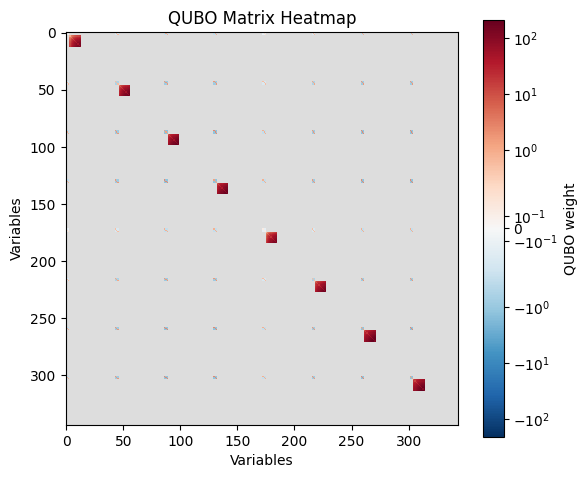

In [349]:
import plot_qb_heatmap
import importlib
importlib.reload(plot_qb_heatmap)
df = qb.to_dataframe(use_labels=True)
plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)

In [350]:
import importlib
from model.constraints import c1, c2, c3_, c4, c5
#importlib.reload(c3)
lam_c1 = 50
lam_c2 = 50
lam3_and = 15
lam3_cap = 15
lam_c4 = 1
lam_c5 = 4

c1.add_startslot_exactly_one_constraints(qb, task, slot, y, lam_c1) 
c2.add_assignment_exactly_one_constraints(qb, task, amr, x, lam_c2) 
c3_.add_c3_capacity_no_overlap_inline(qb, task, amr, slot, x, y, w, lam3_and, lam3_cap)
c4.add_c4_consistency_inline(qb, task, amr, slot, x, y, lam_c4)
c5.add_c5_precedence_inline(qb, task, slot, y, precedence, lam_c5)

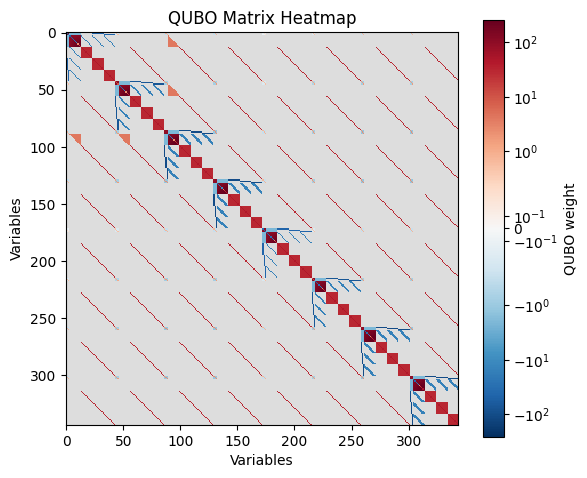

In [351]:
importlib.reload(plot_qb_heatmap)
df = qb.to_dataframe(use_labels=True)
plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)

In [352]:
#optional
import numpy as np
df = qb.to_dataframe()
H_obj = df.filter(like='objective')  # falls du sie getaggt hast
print("QUBO absolute values:", np.percentile(np.abs(df.values), [5,50,95]))

QUBO absolute values: [ 0.  0. 15.]


In [353]:
import dimod, neal
Q = dict(qb.Q) 
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
bqm = dimod.BinaryQuadraticModel.from_qubo(Q_upper)
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=2000, sweeps=5000, beta_range=(0.1, 5.0), seed=123)
print(sampleset)
asym = [((i,j), w - Q.get((j,i),0.0)) for (i,j), w in Q.items() if i>j and abs(w - Q.get((j,i),0.0))>1e-9]
print("Asymmetrien:", len(asym))

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 343 energy num_oc.
1050  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -666.0       1
14    1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0 ...   0 -666.0       1
1552  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -659.4       1
1401  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0 ...   0 -654.8       1
462   1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -653.2       1
191   0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -652.6       1
1788  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0 ...   1 -651.2       1
411   0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -651.0       1
146   1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -650.4       1
1321  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -650.4       1
1017  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -650.2       1
1325  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0

In [354]:
from decode_best_solution import invert_map, decode_sample

inv_x = invert_map(x)        # idx -> (tname, rname)
inv_y = invert_map(y)        # idx -> (tname, z)
inv_w = invert_map(w)    

sample = {int(k): int(v) for k, v in sampleset.first.sample.items()}
chosen_x, chosen_y, chosen_w = decode_sample(sample, inv_x, inv_y, inv_w)
print("X=1:", chosen_x)
print("Y=1:", chosen_y)
print("W=1:", chosen_w)

X=1: [('x', 'T1', 'R2'), ('x', 'T2', 'R1'), ('x', 'T3', 'R1'), ('x', 'T4', 'R3'), ('x', 'T5', 'R3'), ('x', 'T6', 'R3'), ('x', 'T7', 'R2'), ('x', 'T8', 'R3')]
Y=1: [('y', 'T1', 0), ('y', 'T2', 0), ('y', 'T3', 2), ('y', 'T4', 3), ('y', 'T5', 0), ('y', 'T6', 0), ('y', 'T7', 0), ('y', 'T8', 0)]
W=1: [('w', 'T1', 'R2', 0), ('w', 'T2', 'R1', 0), ('w', 'T2', 'R1', 1), ('w', 'T3', 'R1', 2), ('w', 'T3', 'R1', 3), ('w', 'T3', 'R1', 4), ('w', 'T4', 'R3', 3), ('w', 'T4', 'R3', 4), ('w', 'T4', 'R3', 5), ('w', 'T5', 'R3', 7), ('w', 'T6', 'R3', 0), ('w', 'T6', 'R3', 1), ('w', 'T7', 'R2', 1), ('w', 'T7', 'R2', 2), ('w', 'T7', 'R2', 9), ('w', 'T8', 'R3', 2), ('w', 'T8', 'R3', 6), ('w', 'T8', 'R3', 8)]


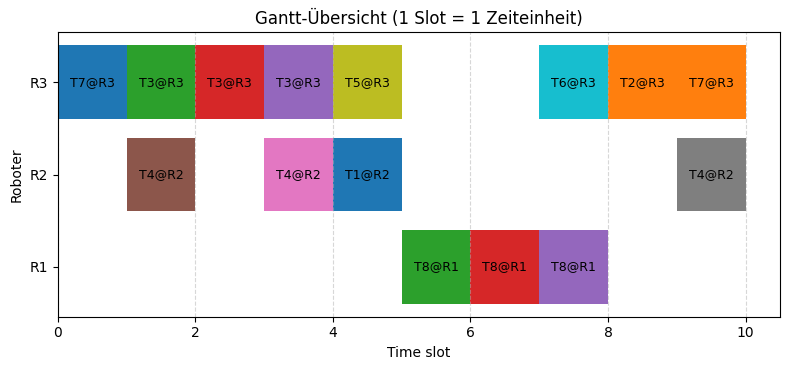

Zuordnung x (Task → Roboter):
  - T1 → R2
  - T2 → R3
  - T3 → R3
  - T4 → R2
  - T5 → R3
  - T6 → R3
  - T7 → R3
  - T8 → R1
Startslots y (Task → Startslot):
  - T1 beginnt bei Slot 4
  - T2 beginnt bei Slot 7
  - T3 beginnt bei Slot 1
  - T4 beginnt bei Slot 9
  - T5 beginnt bei Slot 8
  - T6 beginnt bei Slot 7
  - T7 beginnt bei Slot 9
  - T8 beginnt bei Slot 5
Belegte Slots w (Task, Roboter, Slot):
  - R1 bei Slot 5: T8
  - R1 bei Slot 6: T8
  - R1 bei Slot 7: T8
  - R2 bei Slot 1: T4
  - R2 bei Slot 3: T4
  - R2 bei Slot 4: T1
  - R2 bei Slot 9: T4
  - R3 bei Slot 0: T7
  - R3 bei Slot 1: T3
  - R3 bei Slot 2: T3
  - R3 bei Slot 3: T3
  - R3 bei Slot 4: T5
  - R3 bei Slot 7: T6
  - R3 bei Slot 8: T2
  - R3 bei Slot 9: T7
Keine Konflikte erkannt.


In [346]:
import pandas as pd
import matplotlib.pyplot as plt

# Derive robots and tasks
robots = sorted({r for _, t, r in chosen_x} | {r for _, t, r, z in chosen_w})
tasks = sorted({t for _, t, r in chosen_x} | {t for _, t, z in chosen_y} | {t for _, t, r, z in chosen_w})
slots = sorted({z for _, t, r, z in chosen_w} | {z for _, t, z in chosen_y})

# Build schedule table: rows = time slots, columns = robots, value = list of tasks running
schedule = {r: {z: [] for z in slots} for r in robots}
for _, t, r, z in chosen_w:
    schedule[r][z].append(t)

df = pd.DataFrame({r: [", ".join(schedule[r][z]) if schedule[r][z] else "" for z in slots] for r in robots},
                  index=slots)
df.index.name = "Time slot"

# Detect conflicts (more than one task on the same robot & time slot)
conflicts = []
for r in robots:
    for z in slots:
        if len(schedule[r][z]) > 1:
            conflicts.append((r, z, schedule[r][z]))

# Display the schedule table to the user
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Theoretischer Arbeitsplan (Slots × Roboter)", df)

# Build a simple Gantt-like chart per robot (horizontal bars for each task segment)
# We'll draw each task segment as a single-slot bar (duration = 1) wherever w=1.
# If tasks span consecutive slots, they will appear as adjacent bars.
fig, ax = plt.subplots(figsize=(8, 2 + 0.6*len(robots)))

# Map robots to lanes
robot_to_lane = {r: i for i, r in enumerate(robots)}

# Collect segments: (lane, start, duration, label)
segments = []
for _, t, r, z in chosen_w:
    lane = robot_to_lane[r]
    segments.append((lane, z, 1, f"{t}@{r}"))

# Draw bars
for lane, start, dur, label in segments:
    ax.barh(lane, dur, left=start)
    ax.text(start + dur/2, lane, label, va='center', ha='center', fontsize=9)

ax.set_yticks(list(robot_to_lane.values()), list(robot_to_lane.keys()))
ax.set_xlabel("Time slot")
ax.set_ylabel("Roboter")
ax.set_title("Gantt-Übersicht (1 Slot = 1 Zeiteinheit)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Prepare a short textual summary of assignments and conflicts
summary_lines = []
summary_lines.append("Zuordnung x (Task → Roboter):")
for _, t, r in chosen_x:
    summary_lines.append(f"  - {t} → {r}")
summary_lines.append("Startslots y (Task → Startslot):")
for _, t, z in chosen_y:
    summary_lines.append(f"  - {t} beginnt bei Slot {z}")
summary_lines.append("Belegte Slots w (Task, Roboter, Slot):")
for _, t, r, z in sorted(chosen_w, key=lambda e: (e[2], e[3], e[1])):
    summary_lines.append(f"  - {r} bei Slot {z}: {t}")

if conflicts:
    summary_lines.append("⚠️ Konflikte erkannt (mehr als ein Task auf demselben Roboter im selben Slot):")
    for r, z, ts in conflicts:
        summary_lines.append(f"  - {r} Slot {z}: {', '.join(ts)}")
else:
    summary_lines.append("Keine Konflikte erkannt.")

print("\n".join(summary_lines))